1. Import Dependencies

In [1]:
import cv2
import numpy as np
import mediapipe as mp
import os
import time
import matplotlib.pyplot as plt 

2. Detect keypoints using mp holistic

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    result = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, result

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                                mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=2))


3. Video Capture

In [5]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        #read feed
        ret, frame = cap.read();
        #detecction
        image, results = mediapipe_detection(frame, holistic)
        #draw landmarks
        draw_landmarks(image, results)
        #show
        cv2.imshow('feed', image)
        #close window
        if cv2.waitKey(10) & 0xff == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


4. Extract keypoints
 

In [5]:
def extract_keypoints(results):
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    return lh

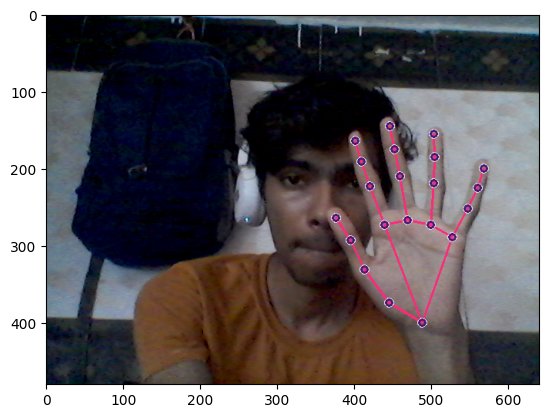

In [15]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [19]:
test = extract_keypoints(results)
np.array(test).shape

(63,)

5. Setup for Collection 

In [6]:
DATA_PATH = os.path.join('Complete')
alphabet = np.array(['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','undo','space'])

In [47]:
for letter in alphabet:
    try:
        os.makedirs(os.path.join(DATA_PATH, letter))
    except:
        pass

6. Collect Keypoints

In [79]:
counter = 0
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        #read feed
        ret, frame = cap.read()
        #detection
        image, results = mediapipe_detection(frame, holistic)
        #draw landmarks
        draw_landmarks(image, results)
        #show to screen
        cv2.imshow('feed', image)
        #saving images
        key = cv2.waitKey(1)
        if key == ord("."):
            
            #new export keypoints
            keypoints = extract_keypoints(results)
            try:
                npy_path = os.path.join(DATA_PATH,alphabet[25],str(counter))
                np.save(npy_path, keypoints)
                counter += 1
            except:
                pass
            print(counter)
        #break on condition
        if cv2.waitKey(10) & 0xff == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

1


7. Preprocessing of Data

In [49]:
DATA_PATH = os.path.join('UV_DATA')
alphabet = np.array(['U','V'])

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [8]:
label_map = {label: num for num, label in enumerate(alphabet)}
label_map

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'K': 9,
 'L': 10,
 'M': 11,
 'N': 12,
 'O': 13,
 'P': 14,
 'Q': 15,
 'R': 16,
 'S': 17,
 'T': 18,
 'U': 19,
 'V': 20,
 'W': 21,
 'X': 22,
 'Y': 23,
 'undo': 24,
 'space': 25}

In [9]:
sequences, labels = [], []
for action in alphabet:
    for sequence in range(2001):
        window = []
        res = np.load(os.path.join(DATA_PATH, action,'{}.npy'.format(sequence)))
        window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [10]:
np.array(sequences).shape

(52026, 1, 63)

In [11]:
x = np.array(sequences)
y = to_categorical(labels).astype(int)

In [83]:
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05)

In [90]:
x_train.shape

(49424, 1, 63)

8. Build & Train LSMT model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [14]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(1,63)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(alphabet.shape[0], activation='softmax'))

In [15]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [16]:
model.fit(x_train,y_train, epochs=50)

Epoch 1/50
1545/1545 [==============================] - 9s 4ms/step - loss: 1.2476 - categorical_accuracy: 0.5672
Epoch 2/50
1545/1545 [==============================] - 6s 4ms/step - loss: 0.3072 - categorical_accuracy: 0.8920
Epoch 3/50
1545/1545 [==============================] - 6s 4ms/step - loss: 0.1947 - categorical_accuracy: 0.9342
Epoch 4/50
1545/1545 [==============================] - 6s 4ms/step - loss: 0.1351 - categorical_accuracy: 0.9555
Epoch 5/50
1545/1545 [==============================] - 6s 4ms/step - loss: 0.0985 - categorical_accuracy: 0.9675
Epoch 6/50
1545/1545 [==============================] - 6s 4ms/step - loss: 0.0731 - categorical_accuracy: 0.9770
Epoch 7/50
1545/1545 [==============================] - 6s 4ms/step - loss: 0.0434 - categorical_accuracy: 0.9876
Epoch 8/50
1545/1545 [==============================] - 7s 4ms/step - loss: 0.0529 - categorical_accuracy: 0.9852
Epoch 9/50
1545/1545 [==============================] - 6s 4ms/step - loss: 0.0315 - cat

In [17]:
model.evaluate(x_train, y_train)

1545/1545 [==============================] - 4s 2ms/step - loss: 0.0074 - categorical_accuracy: 0.9977


[0.007416696287691593, 0.9976732134819031]

9. Predictions

In [22]:
x_predicted = model.predict(x_train)

1545/1545 [==============================] - 3s 2ms/step


In [23]:
x_predicted.shape

(49424, 26)

In [25]:
count = 0
for i in range(49000):
    p = alphabet[np.argmax(x_predicted[i])]
    q = alphabet[np.argmax(y_train[i])]

    if(p != q):
        print(i,p,q)
        count += 1
else:
    print(count)
    


219 C D
966 H G
1886 L T
1969 H G
2189 E D
3603 M T
4169 L S
5180 L V
5873 L C
5901 M N
6805 undo P
6941 L C
7354 C D
8309 L V
8495 L V
9207 M T
9819 L C
9934 L V
9936 L V
9955 L C
10276 L D
11694 Q P
11760 L D
11936 C D
12612 L S
13245 L T
13522 L P
13984 L T
14186 L M
14311 L V
14559 F S
14786 L T
15555 L V
15563 M N
15815 L S
15963 M N
15991 L T
16093 L V
16548 H G
16779 M T
17117 M T
17194 L Y
19029 M T
19381 L V
19903 L V
20620 M N
20792 L M
21101 L T
21626 L V
22136 L H
22529 L D
23072 L C
23303 L M
23599 L V
23667 L V
23795 L T
23952 L S
24019 L D
24986 L V
24990 I T
25010 L S
27008 L M
27150 L D
27441 H G
27708 L D
27853 L T
31557 L M
32479 H G
32729 undo P
33214 L T
33404 H G
33859 M T
34200 L T
34212 I S
34307 L G
34721 L V
34771 M T
34942 M T
34979 Q P
35193 H G
35793 L S
35905 L G
36057 L S
36712 L M
36998 L T
37008 L space
37910 L M
38063 L T
38115 L T
39233 L D
39247 L T
40509 L M
40714 O D
40891 C D
41068 Q P
41267 L S
41525 L T
41695 O D
42324 I S
42520 L V
42782 L H
44

In [65]:
alphabet[(np.argmax(x_predicted[141]))]

'4'

In [67]:
alphabet[np.argmax(y_train[141])]

'7'

In [36]:
count = 0
for i in range(len(y_train)):
    if alphabet[(np.argmax(y_train[i]))] == 'bspace':
        print(i)
        count += 1
    if count >= 10: break 

       

3
7
13
19
29
32
62
78
81
93


10. Save model

In [104]:
model.save('Complete_1.h5')

11. Load model

In [28]:
model.load_weights('ASL_Advanced.h5')

12. Real time testing 

In [26]:
#New detection variables
sentence = []
threshold = 0.7
previous_num = -1
cap = cv2.VideoCapture(0)
#access mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        #read feed
        ret, frame = cap.read()

        #make detection
        image, results = mediapipe_detection(frame, holistic)

        #draw landmarks
        draw_landmarks(image, results)

        #Prediction logic
        keypoints = extract_keypoints(results).reshape(1,-1)
        
        res = model.predict(np.expand_dims(keypoints, axis=0))[0]
        

        #viz logic
        if res[np.argmax(res)] > threshold:
            
            if len(sentence) > 0:
                if alphabet[np.argmax(res)] != sentence[-1]:
                    sentence.append(alphabet[np.argmax(res)])
            else:
                sentence.append(alphabet[np.argmax(res)])  

        if len(sentence) > 1:
            sentence = sentence[-1:] 

        #cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30), cv2.FONT_HERSHEY_SIMPLEX,1 ,(25, 55, 235) , 2, cv2.LINE_AA)
        
        #show to screen
        cv2.imshow('feed', image)

        #break on condition
        if cv2.waitKey(10) & 0xff == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 19ms/step


In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [26]:
yhat = model.predict(x_test)
len(yhat)

15/15 [==============================] - 0s 3ms/step


450

In [27]:
ytrue = np.argmax(y_test, axis=1)
yhat = np.argmax(yhat, axis=1)

In [28]:

cm = confusion_matrix(ytrue, yhat)

Text(95.72222222222221, 0.5, 'Truth')

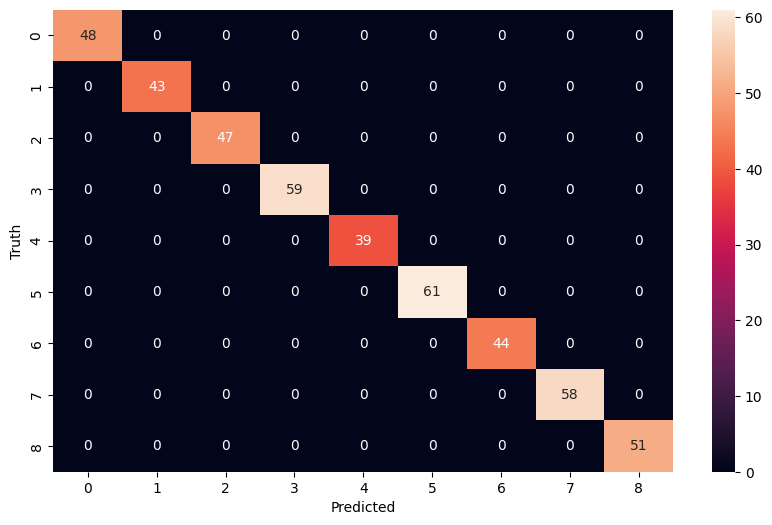

In [29]:
import seaborn as sn
plt.figure(figsize=(10,6))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth') 